In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()
import nest_asyncio
nest_asyncio.apply()

/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


In [2]:
df = pd.read_csv('quality_nj2.csv')
from sklearn.preprocessing import LabelEncoder
encoder1, encoder2, encoder3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
from scipy.spatial.distance import cdist
coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
distances = cdist(coords.T,coords.T, metric='euclidean')
# The categorical variables are now encoded with numerical values

In [27]:
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear
df['ENTRY_CUMCOUNT'] = df.groupby('ENTRY_NAME').cumcount() + 1
df.head()

/tmp/ipykernel_2007/2786646725.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear


,PLT_ID,TRAIT,DATE,QUALITY,ENTRY_CODE,ENTRY_NAME,COMP,RATER,ROW,COL,...,MONTH,RATING_EVENT,RATING_EVENT_CODE,MONTH_CODE,YEAR_CODE,TEST_LOC,ENTRY_NAME_CODE,PLT_ID_CODE,ENTRY_CUMCOUNT,DAY_OF_YEAR
0,241,Turf Quality,4/18/18,4,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,Apr,RMD-2018-04-18,7,1,1,"Adelphia, NJ",62,238,1,108
1,241,Turf Quality,5/10/18,4,37,NAI-14-132,Columbia River Seed,RON,17,1,...,May,RON-2018-05-10,12,6,1,"Adelphia, NJ",62,238,2,130
2,241,Turf Quality,6/7/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,Jun,RON-2018-06-07,13,4,1,"Adelphia, NJ",62,238,3,158
3,241,Turf Quality,7/17/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,Jul,RON-2018-07-17,14,3,1,"Adelphia, NJ",62,238,4,198
4,241,Turf Quality,8/15/18,6,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,Aug,RMD-2018-08-15,8,2,1,"Adelphia, NJ",62,238,5,227


In [50]:
df['ENTRY_NAME'].unique()

array(['NAI-14-132', 'BAR PP 7236V', 'DLFPS-340/3455', 'A15-6',
       'NAI-15-80', 'BAR PP 79366', 'A11-38', 'Yellowstone (A12-7)',
       'MVS-130', 'DLFPS-340/3551', 'DLFPS-340/3550',
       'Twilight (NAI-13-132)', 'A11-40', 'A10-280', 'A06-8',
       'DLFPS-340/3364', 'Babe', 'BAR PP 71213', 'Prosperity', 'AKB3241',
       'DLFPS-340/3552', 'Barvette HGT®', 'Amaze (NAI-14-133)',
       'PST-T14-39', 'Blue Gem (NAI-13-9)', 'Jersey (NAI-A16-3)', 'A13-1',
       'Aviator II (NAI-15-84)', 'Bombay (GO-22B23)', 'PST-K15-172',
       'PST-11-7', 'Dublin (PST-K15-157)', 'PST-K13-141', 'Midnight',
       'DLFPS-340/3444', 'United (NAI-13-14)', 'RAD-1776', 'A99-2897',
       'A16-2', 'AKB3179', 'Blue Knight', 'A12-34', 'Shamrock',
       'DLFPS-340/3438', 'DLFPS-340/3446', 'Blue Devil', 'Pivot',
       'BAR PP 7309V', 'A16-1', 'DLFPS-340/3548', 'NAI-14-122',
       'Barserati (BAR PP 110358)', 'Syrah (LTP-11-41)',
       'Orion (PST-K13-143)', 'Paloma (PST-K13-139)', 'DLFPS-340/3494',
     

In [53]:
df[df['ENTRY_NAME'] == 'Babe']['ENTRY_CUMCOUNT']

648       1
649       2
650       3
651       4
652       5
       ... 
5071    104
5072    105
5073    106
5074    107
5075    108
Name: ENTRY_CUMCOUNT, Length: 108, dtype: int64

In [33]:
padding = 5 # adjustable
num_rows = 18
num_cols = 15
stan_data_time = {"N": len(df["QUALITY"]),
             "I":len(df['RATING_EVENT'].unique()),
             "J":len(df['ENTRY_NAME'].unique()),
             "P":len(df['PLT_ID'].unique()),
             "M": 9,
             "ii": df["RATING_EVENT_CODE"].values+1,
             "jj": df["ENTRY_NAME_CODE"].values+1,
             "pp": df["PLT_ID_CODE"].values+1,
             "y": df["QUALITY"].values,
             "DIST": distances,
              # new values for time data
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int),
             "day" : df['DAY_OF_YEAR'],
             "c_f":1.5, # factor c of basis functions for GP for f1
             "M_f":10, # number of Hilbert Basis 
             "ratings_per_entry": np.max(df.groupby('ENTRY_NAME').count()['PLT_ID']),
             "entry_cumcount": df["ENTRY_CUMCOUNT"],
              }

In [34]:
np.max(df.groupby('ENTRY_NAME').count()['PLT_ID']) # These should all be the same value
np.std(df.groupby('ENTRY_NAME').count()['PLT_ID']) # STD should be 0

0.0

In [39]:
fourier_model_t = compile_model(stan_file="fourier_model_time_effect_distinct_entries.stan", force_compile=True)

20:18:50 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
20:18:50 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect_distinct_entries.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect_distinct_entries
20:19:27 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect_distinct_entries


In [40]:
fit = fourier_model_t.sample(stan_data_time)

20:19:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status


chain 1 |████▍                                                                                            | 00:00 Status
chain 2 |████▍                                                                                            | 00:00 Status

chain 1 |████████▋                                                       | 01:24 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████▊                                                          | 14:02 Iteration:


23:09:05 - cmdstanpy - INFO - CmdStan done processing.
23:09:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distinct_entries.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect_distinct_entries.stan', line 135, column 1 to column 103)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distinct_entries.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect_distinct_entries.stan', line 135, column 1 to column 103)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distinct_entries.stan', line 13, column 4 to column 40) (in 'fourier_m

23:09:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 iterations at max treedepth (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [41]:
fit.time_effect

array([[[ 0.279785  ,  0.14044   ,  0.00686513, ...,  0.0587712 ,
          0.19173   ,  0.41535   ],
        [ 1.01461   , -0.583362  , -1.16966   , ...,  0.343298  ,
          0.71503   ,  0.770366  ],
        [ 0.962787  ,  1.56496   ,  1.49718   , ...,  0.817979  ,
          2.49415   ,  0.282274  ],
        ...,
        [ 0.0997892 ,  0.211358  ,  0.379734  , ...,  0.478213  ,
          0.321146  ,  0.111108  ],
        [-1.02788   , -0.861785  , -0.384331  , ...,  0.654258  ,
          0.608022  ,  0.455983  ],
        [ 0.420615  ,  0.840711  ,  0.563333  , ...,  0.177391  ,
         -0.246815  , -0.178838  ]],

       [[-0.113528  , -0.119487  , -0.00442634, ..., -0.00315265,
          0.0774352 ,  0.345559  ],
        [ 0.531932  , -0.544225  , -1.0219    , ...,  0.188065  ,
          0.496955  , -0.247082  ],
        [ 0.913607  ,  1.23531   ,  1.10871   , ...,  1.21089   ,
          1.87482   ,  1.8955    ],
        ...,
        [ 0.258015  , -0.332976  ,  0.457899  , ...,  

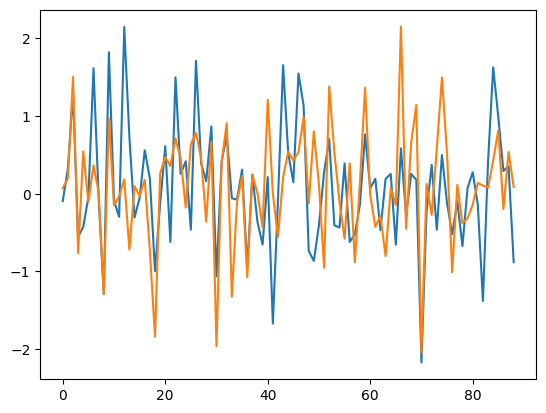

In [49]:
for i in range(4,6):
    plt.plot(fit.time_effect[i].mean(axis=1))

In [ ]:
plt.scatter(stan_data_time["day"],fit_time.time_effect.mean(axis=0),s=2)

In [55]:
"day" : df['DAY_OF_YEAR']

AttributeError: Unknown variable name: day
Available variables are beta_free, tau_free, entry, sigma, alpha_plot, z, mu, length_scale, z_time, sigma_time, intercept_f, beta_f, lengthscale_f, sigma_f, theta, beta, tau, plot, time_effect, rfft2_cov, f, mean_day, sd_day, L_f, diagSPD_f, PHI_f, xn